In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import sys

sys.path.append("../")
import loss_functions as ls
import utils as ut
from models import Model
from layers import Linear, Flatten
from activation_functions import Sigmoid, Tanh, ReLU, LeakyReLU

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tqdm import tqdm
from collections import Counter

In [16]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torch
from collections import Counter

# Define transformations to flatten and normalize the data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Lambda(lambda x: x.view(-1)),
    ]
)

# Load MNIST dataset
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

num_classes = 10
samples_per_class = 10000  # 10k total samples, 1k per class
class_counts = {i: 0 for i in range(num_classes)}
balanced_indices = []

# Iterate through the dataset to collect indices
for idx, (image, label) in enumerate(train_dataset):
    if class_counts[label] < samples_per_class:
        balanced_indices.append(idx)
        class_counts[label] += 1
    if sum(class_counts.values()) == num_classes * samples_per_class:
        break

# Create a subset using the balanced indices
train_dataset = Subset(train_dataset, balanced_indices)

# Split train dataset into train and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

# Convert datasets to NumPy arrays
train_data = [(data.numpy(), label) for data, label in train_dataset]
val_data = [(data.numpy(), label) for data, label in val_dataset]
test_data = [(data.numpy(), label) for data, label in test_dataset]

# Separate features and labels
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)
X_test, y_test = zip(*test_data)

# Convert to NumPy arrays
X_train, y_train = np.array(X_train), np.expand_dims(np.array(y_train), axis=1)
X_val, y_val = np.array(X_val), np.expand_dims(np.array(y_val), axis=1)
X_test, y_test = np.array(X_test), np.expand_dims(np.array(y_test), axis=1)


print(f"Train data shape: {X_train.shape}, Train labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}, Validation labels shape: {y_val.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {y_test.shape}")

Train data shape: (48000, 784), Train labels shape: (48000, 1)
Validation data shape: (12000, 784), Validation labels shape: (12000, 1)
Test data shape: (10000, 784), Test labels shape: (10000, 1)


In [17]:
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Scaled Train data shape: {X_train_scaled.shape}")
print(f"Scaled Validation data shape: {X_val_scaled.shape}")
print(f"Scaled Test data shape: {X_test_scaled.shape}")

X_train = X_train_scaled
X_val = X_val_scaled
X_test = X_test_scaled

Scaled Train data shape: (48000, 784)
Scaled Validation data shape: (12000, 784)
Scaled Test data shape: (10000, 784)


In [34]:
model = Model(ls.multi_cross_entropy)
model.add(Linear(28 * 28, 128, ReLU()))
model.add(Linear(128, 64, ReLU()))
model.add(Linear(64, 10, None))

loss, train_predictions, test_predictions = model.fit(
    (X_train, y_train),
    10,
    0.01,
    batch_size=1024 * 5,
    logging_predictions=True,
    one_hot=True,
    validation_data=(X_val, y_val),
)

Training epoch 0
Epoch 0 loss -> 2.3061065845885658
Validation loss -> 23.47806523264456
Training epoch 1
Epoch 1 loss -> 2.2409459675619408
Validation loss -> 22.766625461711506
Training epoch 2
Epoch 2 loss -> 2.1726810160755763
Validation loss -> 22.060917120772157
Training epoch 3
Epoch 3 loss -> 2.108985667242992
Validation loss -> 21.42236933970325
Training epoch 4
Epoch 4 loss -> 2.0515558261634603
Validation loss -> 20.865414418527187
Training epoch 5
Epoch 5 loss -> 2.0010996924225655
Validation loss -> 20.37759235559007
Training epoch 6
Epoch 6 loss -> 1.9573889073392614
Validation loss -> 19.960797334665223
Training epoch 7
Epoch 7 loss -> 1.919426483573923
Validation loss -> 19.617832952915208
Training epoch 8
Epoch 8 loss -> 1.8898615493255972
Validation loss -> 19.34941491536034
Training epoch 9
Epoch 9 loss -> 1.8664278560217176
Validation loss -> 19.147427799396212


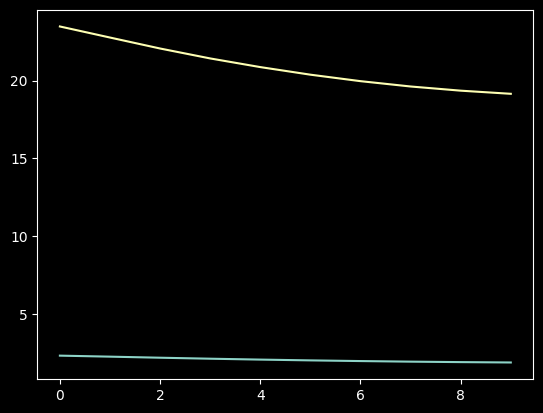

In [35]:
plt.plot(loss["train"], label="Train Loss")
plt.plot(loss["val"], label="Validation Loss")

# Evaluate

In [36]:
print(f"X_test shape: {X_test.shape}")
predictions = model.predict(X_test)  #
print(f"Predictions shape: {predictions.shape}")
correct = np.sum(np.argmax(predictions, axis=1) == np.squeeze(y_test))
accuracy = correct / len(y_test) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

X_test shape: (10000, 784)
Predictions shape: (10000, 10)
Test Accuracy: 63.00%
